In [6]:
# !git clone https://github.com/sizhky/zero-shot-learning/

In [7]:
!pip install -Uq torch_snippets

In [8]:
%cd zero-shot-learning/src

/home/delameta/ramma/NoteRM/Implementing_zero-shot_Learning_Deeplearning_Project/training/zero-shot-learning/src/zero-shot-learning/src


In [9]:
%ls

detect_object.py      train_classes.txt  zsl_classes.txt
feature_extractor.py  train.py


In [10]:
import gzip, _pickle as cPickle 
from torch_snippets import * 
from sklearn.preprocessing import LabelEncoder, normalize 
device  = 'cuda' if torch.cuda.is_available() else 'cpu'


/home/delameta/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
WORD2VECPATH = "../data/class_vectors.npy"
DATAPATH = "../data/zeroshot_data.pkl"

with open('train_classes.txt', 'r') as infile:
    train_classes = [str.strip(line) for line in infile]
    print(train_classes)

[
    'arm',
    'boy',
    'bread',
    'chicken',
    'child',
    'computer',
    'ear',
    'house',
    'leg',
    'sandwich',
    'television',
    'truck',
    'vehicle',
    'watch',
    'woman'
]

In [12]:
with gzip.GzipFile(DATAPATH, 'rb') as infile:
    data = cPickle.load(infile)

In [13]:
training_data = [instance for instance in data if instance[0] in train_classes]
zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
np.random.shuffle(training_data)

In [14]:
train_size = 300 # per class
train_data, valid_data = [], []
for class_label in train_classes:
    ctr = 0
    for instance in training_data:
        if instance[0] == class_label:
            if ctr < train_size:
                train_data.append(instance)
                ctr+=1
            else:
                valid_data.append(instance)

In [15]:
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
vectors = {i:j for i,j in np.load(WORD2VECPATH, allow_pickle=True)}

In [20]:
train_data=[(feat,vectors[clss]) for clss,feat in train_data]
valid_data=[(feat,vectors[clss]) for clss,feat in valid_data]

In [21]:
train_clss = [clss for clss, feat in train_data]
valid_clss = [clss for clss, feat in valid_data]
zero_shot_clss = [clss for clss, feat in zero_shot_data]


In [22]:
x_train, y_train = zip(*train_data)
x_train, y_train = np.squeeze(np.asarray(x_train)),np.squeeze(np.asarray(y_train))
x_train = normalize(x_train, norm='l2')
x_valid, y_valid = zip(*valid_data)
x_valid, y_valid = np.squeeze(np.asarray(x_valid)),np.squeeze(np.asarray(y_valid))
x_valid = normalize(x_valid, norm='l2')
y_zsl, x_zsl = zip(*zero_shot_data)
x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)),np.squeeze(np.asarray(y_zsl))
x_zsl = normalize(x_zsl, norm='l2')

In [23]:
from torch.utils.data import TensorDataset
trn_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])
trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [24]:
def build_model():
    return nn.Sequential(
        nn.Linear(4096, 1024), nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024), nn.Dropout(0.8),
        nn.Linear(1024, 512), nn.ReLU(inplace=True),
        nn.BatchNorm1d(512), nn.Dropout(0.8),
        nn.Linear(512, 256), nn.ReLU(inplace=True),
        nn.BatchNorm1d(256), nn.Dropout(0.8),
        nn.Linear(256, 300)
)

In [25]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss = criterion(_preds, labels)
    return loss.item()

EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.015	(11.68s - 58.42s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.015	(11.69s - 58.43s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.015	(11.69s - 58.44s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.44s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.45s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.45s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.46s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.47s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.69s - 58.47s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.70s - 58.48s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.014	(11.70s - 58.48s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.015	(11.70s - 58.49s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss: 0.015	(11.70s - 58.50s remaining)
EPOCH: 10.000	trn_loss: 0.019	val_loss

100%|██████████| 161/161 [00:00<00:00, 581.40it/s]


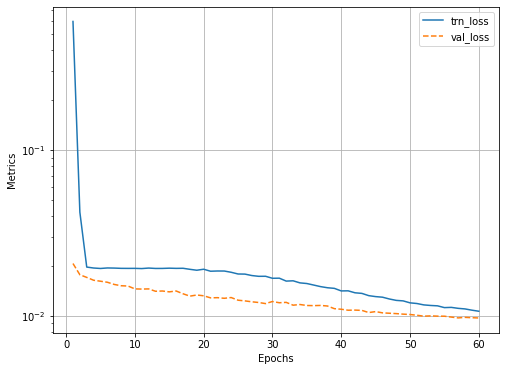

In [26]:
model = build_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 60
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, end='\r')
        if not (ex+1)%10: log.report_avgs(ex+1)
log.plot_epochs(log=True)

In [27]:
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()
class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)
vectors = np.array(vectors)

In [28]:
dists = (pred_zsl[None] - vectors[:,None])
dists = (dists**2).sum(-1).T
best_classes = []
for item in dists:
    best_classes.append([classnames[j] for j in np.argsort(item)[:5]])
np.mean([i in J for i,J in zip(zero_shot_clss, best_classes)])

0.7958979489744873